## Setup

In [ ]:
# Libraries
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os

# Seeds
np.random.seed(42)
tf.random.set_seed(42)

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
project_root_dir = '/content/drive/My Drive/CS_229_project/'

Mounted at /content/drive/


In [ ]:
aqi_dir = os.path.join(project_root_dir, 'aqi_data', 'final_data')
experiments_dir = os.path.join(project_root_dir, 'experiments')
img_dir = os.path.join(project_root_dir, 'img_data')

# Simple pixel-level softmax

## Preliminaries

In [ ]:
# Load training, validation, and test X datasets
train = np.load(os.path.join(experiments_dir, 'train.npz'))
valid = np.load(os.path.join(experiments_dir, 'valid.npz'))
test = np.load(os.path.join(experiments_dir, 'test.npz'))

In [ ]:
train['x'].shape

(3333, 224, 224, 3)

In [ ]:
from collections import Counter
item_ct = Counter(train['y'])
max_ct = float(max(item_ct.values()))
class_wts = {class_id: max_ct / num_img for class_id, num_img in item_ct.items()}
class_wts

{0: 1.0, 1: 1.800990099009901, 2: 3.609126984126984}

In [ ]:
no_class_wts = {'0': 1, '1': 1, '2': 1}

In [ ]:
# Center and scale training and validation X
x_mean = train['x'].mean(axis = 0, keepdims = True)
x_std = train['x'].std(axis = 0, keepdims = True) + 1e-7
x_train = (train['x'] - x_mean) / x_std
x_valid = (valid['x'] - x_mean) / x_std

In [ ]:
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
x_valid_flattened = x_valid.reshape(x_valid.shape[0], -1)

In [ ]:
from gc import collect
del x_train, x_valid
collect()

27

In [ ]:
x_all = np.concatenate((x_train_flattened, x_valid_flattened))
y_all = np.concatenate((train['y'], valid['y']))

In [ ]:
print(x_all.shape)
print(y_all.shape)

(4444, 150528)
(4444,)


In [ ]:
collect()
del x_train_flattened, x_valid_flattened

## SGD Classifier

### Basic fit

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42, loss = 'hinge', class_weight = class_wts, alpha = 1, penalty = 'l2', verbose = True)

In [ ]:
sgd_clf.fit(x_all, y_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 1.43, NNZs: 150528, Bias: 0.926374, T: 4444, Avg. loss: 89.128954
Total training time: 1.34 seconds.
-- Epoch 2
Norm: 0.99, NNZs: 150528, Bias: 0.957580, T: 8888, Avg. loss: 3.434913
Total training time: 2.61 seconds.
-- Epoch 3
Norm: 0.85, NNZs: 150528, Bias: 0.972356, T: 13332, Avg. loss: 1.974338
Total training time: 3.88 seconds.
-- Epoch 4
Norm: 0.74, NNZs: 150528, Bias: 0.983139, T: 17776, Avg. loss: 1.459041
Total training time: 5.13 seconds.
-- Epoch 5
Norm: 0.69, NNZs: 150528, Bias: 0.984807, T: 22220, Avg. loss: 1.121206
Total training time: 6.38 seconds.
-- Epoch 6
Norm: 0.65, NNZs: 150528, Bias: 0.986437, T: 26664, Avg. loss: 0.926372
Total training time: 7.64 seconds.
-- Epoch 7
Norm: 0.62, NNZs: 150528, Bias: 0.985326, T: 31108, Avg. loss: 0.858177
Total training time: 8.91 seconds.
-- Epoch 8
Norm: 0.59, NNZs: 150528, Bias: 0.982070, T: 35552, Avg. loss: 0.741488
Total training time: 10.16 seconds.
-- Epoch 9
Norm: 0.57, NNZs: 150528, Bias: 0.980323, T: 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.2min finished


SGDClassifier(alpha=1, average=False,
              class_weight={0: 1.0, 1: 1.800990099009901, 2: 3.609126984126984},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=True, warm_start=False)

### SVC

In [ ]:
from sklearn.svm import SVC
svc_clf = SVC(random_state = 42, class_weight = class_wts, C = 1, verbose = True)

In [ ]:
svc_clf.fit(x_all, y_all)
test_preds = svc_clf.predict(x_test_flattened)
test_accuracy = accuracy_score(test['y'], test_preds)
test_accuracy
train_preds = svc_clf.predict(x_all)
train_accuracy = accuracy_score(y_all, train_preds)
train_accuracy

[LibSVM]

0.7072457245724573

In [ ]:
test_preds = svc_clf.predict(x_test_flattened)
test_accuracy = accuracy_score(test['y'], test_preds)
test_accuracy

0.6453645364536453

In [ ]:
train_preds = svc_clf.predict(x_all)
train_accuracy = accuracy_score(y_all, train_preds)
train_accuracy

0.7072457245724573

### Grid search

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'alpha' : [1, 2, 3, 4]}]
sgd_clf = SGDClassifier(random_state = 42, loss = 'hinge', class_weight = class_wts, penalty = 'l2')
grid_search = GridSearchCV(sgd_clf, param_grid, cv = 3, return_train_score = True)
grid_search.fit(x_all, y_all)

GridSearchCV(cv=3, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight={0: 1.0, 1: 1.800990099009901,
                                                   2: 3.609126984126984},
                                     early_stopping=False, epsilon=0.1,
                                     eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [1, 2, 3, 4]}], pre_dispatch='2*n_jobs',

In [ ]:
grid_search.cv_results_

{'mean_fit_time': array([210.99384753, 213.06367358, 193.54496217, 218.10130143]),
 'mean_score_time': array([0.64045612, 0.64905866, 0.65924843, 0.60520848]),
 'mean_test_score': array([0.53510534, 0.50427517, 0.49887539, 0.49865062]),
 'mean_train_score': array([0.91246573, 0.87623689, 0.84338304, 0.82830762]),
 'param_alpha': masked_array(data=[1, 2, 3, 4],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 1}, {'alpha': 2}, {'alpha': 3}, {'alpha': 4}],
 'rank_test_score': array([1, 2, 3, 4], dtype=int32),
 'split0_test_score': array([0.52699055, 0.50539811, 0.49662618, 0.49527665]),
 'split0_train_score': array([0.90783255, 0.86968265, 0.83187036, 0.8264686 ]),
 'split1_test_score': array([0.50844024, 0.50844024, 0.50573937, 0.50506415]),
 'split1_train_score': array([0.89503881, 0.8720891 , 0.84070199, 0.82956463]),
 'split2_test_score': array([0.56988521, 0.49898717, 0.49426063, 0.49561107]),
 'split2_train_s

## Evaluation

### Test Data Setup

In [ ]:
x_mean_test = test['x'].mean(axis = 0, keepdims = True)
x_std_test = test['x'].std(axis = 0, keepdims = True) + 1e-7
x_test = (test['x'] - x_mean_test) / x_std_test
x_test_flattened = x_test.reshape(x_test.shape[0], -1)

In [ ]:
collect()
del x_test

In [ ]:
directory_name = 'bias_variance'
directory_name = os.path.join(experiments_dir, 'model_results', directory_name)
directory_name

'/content/drive/My Drive/CS_229_project/experiments/model_results/bias_variance'

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

Things to try:

* Try getting more training examples
* Try a smaller set of features
* Try a larger set of features
* Run gradient descent for more iterations
* Try Newton's method
* Use a different value of lambda
* Try using a SVM



### Bias Variance Curve

In [ ]:
from collections import Counter
from gc import collect
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import log_loss
import seaborn as sns

In [ ]:
train = np.load(os.path.join(experiments_dir, 'train.npz'))
valid = np.load(os.path.join(experiments_dir, 'valid.npz'))
test = np.load(os.path.join(experiments_dir, 'test.npz'))

In [ ]:
n_train = train['x'].shape[0]
n_valid = valid['x'].shape[0]
seq_train = np.linspace(100, n_train, dtype = int, num = 10)
seq_valid = np.linspace(100, n_valid, dtype = int, num = 10)
idx_train = [np.random.choice(n_train, size = i, replace = False) for i in seq_train]
idx_valid = [np.random.choice(n_valid, size = i, replace = False) for i in seq_valid]

In [ ]:
collect()
len(idx_valid[9])

1111

In [ ]:
for i in range(0,len(idx_train)):
  # Load training, validation, and test X datasets
  item_ct = Counter(train['y'][idx_train[i]])
  max_ct = float(max(item_ct.values()))
  class_wts = {class_id: max_ct / num_img for class_id, num_img in item_ct.items()}

  # Center and scale training and validation X
  x_mean = train['x'][idx_train[i],:].mean(axis = 0, keepdims = True)
  x_std = train['x'][idx_train[i],:].std(axis = 0, keepdims = True) + 1e-7
  x_train = (train['x'][idx_train[i],:] - x_mean) / x_std
  x_valid = (valid['x'][idx_valid[i],:] - x_mean) / x_std

  x_train_flattened = x_train.reshape(x_train.shape[0], -1)
  x_valid_flattened = x_valid.reshape(x_valid.shape[0], -1)
  del x_train
  del x_valid
  collect()

  x_all = np.concatenate((x_train_flattened, x_valid_flattened))
  y_all = np.concatenate((train['y'][idx_train[i]], valid['y'][idx_valid[i]]))
  collect()
  del x_train_flattened, x_valid_flattened

  sgd_clf = SGDClassifier(random_state = 42, loss = 'hinge', alpha = 1, class_weight = class_wts, penalty = 'l2', verbose = False)
  sgd_clf.fit(x_all, y_all)

  x_test = (test['x'] - x_mean) / x_std
  x_test_flattened = x_test.reshape(x_test.shape[0], -1)

  #test_predsa = sgd_clf.predict_proba(x_test_flattened)
  test_preds = sgd_clf.predict(x_test_flattened)
  #test_accuracya = log_loss(test['y'], test_predsa)
  test_accuracy = accuracy_score(test['y'], test_preds)

  #train_predsa = sgd_clf.predict_proba(x_all)
  #train_accuracya = log_loss(y_all, train_predsa)

  train_preds = sgd_clf.predict(x_all)
  train_accuracy = accuracy_score(y_all, train_preds)

  print(len(y_all))
  #print(test_accuracya)
  #print(train_accuracya)
  print(test_accuracy)
  print(train_accuracy)
  
  # Remove previous models if needed
  del sgd_clf
  del y_all
  del x_all
  del x_test
  collect()

200
0.49864986498649866
0.905
671
0.5508550855085509
0.9567809239940388
1142
0.5445544554455446
0.9150612959719789
1614
0.6165616561656165
0.9405204460966543
2085
0.6174617461746175
0.9189448441247002
2557
0.6156615661566157
0.8775909268674228
3029
0.6417641764176417
0.9052492571805877
3500
0.6336633663366337
0.902
3971
0.6453645364536453
0.8894485016368673
4444
0.6543654365436543
0.8852385238523852


(Size, Test Error, Train Error)

** Results with early stopping and internal validation sets**

200
0.46984698469846986
0.765

671
0.49414941494149417
0.7332339791356185

1142
0.5553555355535553
0.7338003502626971

1614
0.5301530153015301
0.6970260223048327

2085
0.5391539153915391
0.6834532374100719

2557
0.5148514851485149
0.6429409464215878

3029
0.5517551755175517
0.6989105315285573

3500
0.47794779477947796
0.6022857142857143

3971
0.48424842484248426
0.5774364140015109

4444
0.5553555355535553
0.6863186318631863

** Results without internal validation with elastic net**

200
0.54995499549955
0.98

671
0.5589558955895589
0.9716840536512668

1142
0.5778577857785778
0.9816112084063048

1614
0.5814581458145814
0.9671623296158612

2085
0.5904590459045904
0.9055155875299761

2557
0.6210621062106211
0.9745795854517012

3029
0.6111611161116112
0.9438758666226478

3500
0.6408640864086409
0.958

3971
0.6237623762376238
0.9576932762528331

4444
0.6345634563456346
0.9507200720072008




200
0.5148514851485149
0.935
671
0.5364536453645364
0.8777943368107303
1142
0.54005400540054
0.9054290718038529
1614
0.5418541854185418
0.8141263940520446
2085
0.5751575157515751
0.8983213429256595
2557
0.5895589558955896
0.8259679311693391
3029
0.6255625562556255
0.8669527896995708
3500
0.6498649864986499
0.932
3971
0.6237623762376238
0.9597078821455552

### Accuracy

In [ ]:
test_preds = sgd_clf.predict(x_test_flattened)
test_accuracy = accuracy_score(test['y'], test_preds)
test_accuracy

0.6624662466246625

In [ ]:
train_prob = sgd_clf.predict_proba(x_all)
log_loss(y_all, train_prob)

In [ ]:
train_preds = sgd_clf.predict(x_all)
train_accuracy = accuracy_score(y_all, train_preds)
train_accuracy

0.880963096309631

In [ ]:
test_prob = sgd_clf.predict_proba(x_test_flattened)
log_loss(test['y'], test_prob)

9.755402781681598

In [ ]:
sklearn.metrics.f1_score(test['y'], preds, average = 'macro')

NameError: ignored

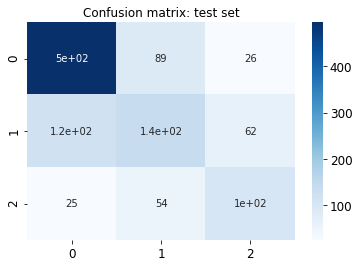

In [ ]:
ax = plt.subplot()
test_cf_matrix = confusion_matrix(test['y'], test_preds)
sns.heatmap(test_cf_matrix, annot = True, ax = ax, cmap = 'Blues')
plt.title('Confusion matrix: test set')
plt.savefig(os.path.join(directory_name, 'test_set_cf_matrix_0.6.png'))
plt.show()

In [ ]:
eval_df = pd.DataFrame(columns = ['set', 'loss', 'accuracy'])
eval_df.loc[0] = ['test', 'hinge_loss', test_accuracy]
eval_df.to_csv(os.path.join(directory_name, 'eval_df_0.6.csv'))

### Predictions

In [26]:
pred = np.load(os.path.join(experiments_dir, 'x_pred.npy'))
pred.shape

(58, 224, 224, 3)

In [ ]:
x_pred_flattened = pred.reshape(pred.shape[0], -1)

In [ ]:
x_mean_pred = pred.mean(axis = 0, keepdims = True)
x_std_pred = pred.std(axis = 0, keepdims = True) + 1e-7
x_pred = (pred - x_mean) / x_std
x_pred_flattened = x_pred.reshape(x_pred.shape[0], -1)
x_pred_flattened.shape

(58, 150528)

In [ ]:
collect()
del x_pred

In [ ]:
pred_preds = sgd_clf.predict(x_pred_flattened)

In [ ]:
pred_preds

array([2, 1, 0, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 2, 2, 1, 0, 2, 2, 1, 2, 0,
       1, 2, 2, 0, 2, 0, 1, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 1, 2,
       0, 2, 2, 0, 0, 0, 2, 0, 1, 0, 2, 1, 2, 1])

In [ ]:
len(pred_preds)

58

In [ ]:
import pandas as pd 
pd.DataFrame(pred_preds).to_csv(os.path.join(experiments_dir, 'preds.csv'))